In [1]:
import pymongo
import pandas as pd
import numpy as np

from pymongo import MongoClient
from bson.objectid import ObjectId

import datetime

import matplotlib.pyplot as plt

from collections import defaultdict


%matplotlib inline
import json
plt.style.use('ggplot')

import seaborn as sns

from math import log10, floor

from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer



from sklearn.cluster import KMeans, MiniBatchKMeans

# CU Woot Math Method 2 for unsupervosed discovery of new behavior traits
## 1) Convert response field dictionary into a document
## 2) Develop word vector using term frequency - inverse document frequency
## 3) Use K-Means to cluster documents
## 4) Map traits to clusters to validate technique


In the first results presented to Woot Math a 100K sample of the entire data set was chosen. In this report, I'll start with the same type of analysis to develop the same heat map. In the meeting Sean and Brent suggested using just one of the qual_id and repeat the experiment and then look at the samples in clusers without traits. I'll do that in a subsequent analysis



## Part 1. Heat map with 100 K sample of all qual_id's

In [2]:
## Connect to local DB

client = MongoClient('localhost', 27017)
print ("Setup db access")

Setup db access


In [3]:
#
# Get collections from mongodb
#
#db = client.my_test_db
db = client.test


In [4]:
chunk = 100000
start = 0
end = start + chunk

In [5]:
#reponses = db.anon_student_task_responses.find({'correct':False})[start:end]
reponses = db.anon_student_task_responses.find()[start:end]

In [6]:
df_responses = pd.DataFrame(list(reponses))

In [7]:
print (df_responses.shape)

(100000, 27)


In [8]:
##  Make the documents to be analyzed

In [9]:
## Functions for turning dictionary into document

def make_string_from_list(key, elem_list):
    # Append key to each item in list
    ans = ''
    for elem in elem_list:
        ans += key + '_' + elem 
        
    
        
    

def make_string(elem, key=None, top=True):
    ans = ''
    if not elem:
        return ans
    if top:
        top = False
        top_keys = []
        for idx in range(len(elem.keys())):
            top_keys.append(True)
            
    for idx, key in enumerate(elem.keys()):
        if top_keys[idx]:
            top = True
            top_keys[idx] = False
            ans += ' '
        else:
            top = False
        #print ('ans = ', ans)
        #print (type(elem[key]))
        if type(elem[key]) is str or\
                type(elem[key]) is int:
            #print ('add value', elem[key])
            value = str(elem[key])
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        elif type(elem[key]) is list:
            #print ('add list', elem[key])
            temp_elem = dict()
            for item in elem[key]:
                temp_elem[key] = item
                ans += make_string(temp_elem, top) 
        elif type(elem[key]) is dict:
            #print ('add dict', elem[key])
            for item_key in elem[key].keys():
                temp_elem = dict()
                temp_elem[item_key] = elem[key][item_key]
                ans += key + '_' + make_string(temp_elem, top)
        elif type(elem[key]) is float:
            #print ('add dict', elem[key])
            sig = 2
            value = elem[key]
            value = round(value, sig-int(
            floor(log10(abs(value))))-1)
            value = str(value)
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        # ans += ' ' + key + ' '
        #print ('not handled', elem[key])
     
        
    return ans

In [10]:
# Makes the cut & paste below easier
df3 = df_responses

In [11]:
df3['response_doc'] = df3['response'].map(make_string)


In [12]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace('/','_'))
df3['response_doc'] = df3['response_doc'] + ' ' + df3['txt'] 
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("\n", ""))
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("?", " "))

In [13]:
data_samples = df3['response_doc']

In [14]:
n_features = 1000
n_samples = len(data_samples)
n_topics = 50
n_top_words = 20

In [15]:
print("Extracting tf-idf features ...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features ...
done in 7.388s.


In [16]:
# Number of clusters
true_k = 100

km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, random_state=42)

In [17]:
print("Clustering with %s" % km)
t0 = time()
km.fit(tfidf)
print("done in %0.3fs" % (time() - t0))
print()

Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=42, reassignment_ratio=0.01,
        tol=0.0, verbose=0)
done in 2.782s



In [18]:
print("Top terms per cluster:")


order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:\n" % i, end='')
    for ind in order_centroids[i, :30]:
        print(' --- %s\n' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0:
 --- write
 --- used
 --- divideboth
 --- denominator
 --- numerator
 --- form
 --- simplest
 --- number
 --- enter
 --- divide
 --- answer
 --- 12
 --- 15
 --- 10
 --- den_8
 --- far
 --- line
 --- fraction_input_value_3_8
 --- whole_
 --- num_3
 --- fraction
 --- fraction_input_value_2_8
 --- fraction_input_value_1_8
 --- num_2
 --- num_1
 --- fraction_input_value_2_4
 --- fraction_circle_containment_
 --- fraction_circle_total_count_13
 --- fraction_input_value_3
 --- fraction_circle_total_count_12

Cluster 1:
 --- fraction_cblock_chains_
 --- pieces_1_8
 --- lcm_sum_
 --- sum_
 --- __as3_type_fraction
 --- denominator_8
 --- numerator_1
 --- denominator_1
 --- bar1_
 --- fraction_cblock_counts_
 --- fraction
 --- fraction_cblock_containment_
 --- numerator_8
 --- left_130
 --- denominator_4
 --- pieces_1
 --- numerator_5
 --- denominator_2
 --- numerator_3
 --- right_820
 --- left_176
 --- numerator_7
 --- left_100
 --- 1_4_
 --- 1_8_8
 --- bar2_
 

In [19]:
# DO 10 runs with a variety of random seedsand collect clusters each time
# Look at cluster with over X percent of a trait.
# The cluster number will chane from run to run
# but we should see the same traits clustered together after each run

In [20]:
def plot_trait_heat_map(df):
    fig = plt.figure(figsize=(18.5, 16))
    cmap = sns.cubehelix_palette(light=.95, as_cmap=True)
    sns.heatmap(df, cmap=cmap,  linewidths=.5)
    plt.show()
    

In [21]:
def organize_clusters_and_traits(df, km):
    df['cluster_100'] = km.labels_
    df_cluster_100 = df.groupby('cluster_100')
    
    
    df['trait_1'] = df['behavioral_traits'].apply(lambda x : x[0] if len(x) > 0 else 'None' )
    df['trait_2'] = df['behavioral_traits'].apply(lambda x : x[1] if len(x) > 1 else 'None' ) 
    df_trait_1 = df.groupby(['cluster_100', 'trait_1']).size().unstack(fill_value=0)
    df_trait_2 = df.groupby(['cluster_100', 'trait_2']).size().unstack(fill_value=0)
    df_trait_1.index.rename('cluster_100', inplace=True)
    df_trait_2.index.rename('cluster_100', inplace=True)
    for column in df_trait_1.columns:
        if column in df_trait_2.columns:
            df_trait_1[column] =  df_trait_1[column] + df_trait_2[column]
            df_trait_2.drop(column, axis=1, inplace=True)
    df_traits = pd.concat([df_trait_1, df_trait_2], axis=1, verify_integrity=True)
    df_traits = df_traits.drop('None', axis=1)
    df_traits_norm = (df_traits  / (df_traits.sum()) )
    df_traits_norm.sort_index(axis=1, inplace=True)
    column_list = list(df_traits_norm.columns)
    df_traits_norm = df_traits_norm.sort_values(by=column_list, axis=0)
    '''
    for column in column_list:
        print (column)
        df_traits_norm = df_traits_norm.sort_values(by=[column], axis=0)
        df_traits_norm = df_traits_norm.reindex()
    '''
    
    return df_traits_norm
    

In [22]:
def make_cluster(
                    data_samples, 
                    num_clusters=100,
                    n_features=1000, 
                    n_topics=50, 
                    n_top_words=20, 
                    random_state=42):
    
    n_samples = len(data_samples)
    print("Extracting tf-idf features ...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')
    t0 = time()
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    print("done in %0.3fs." % (time() - t0))
    # Number of clusters


    km = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, random_state=random_state)
    print("Clustering with %s" % km)
    t0 = time()
    km.fit(tfidf)
    print("done in %0.3fs" % (time() - t0))
    print()
    
    return km

    
    
    

In [23]:
random_states = [42,12,15,52,62,72,5,88,45,100]

In [24]:
# Using same set of data samples create 10 sets of clusters with differet random starts

In [25]:
trait_maps = []

Extracting tf-idf features ...
done in 7.030s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=42, reassignment_ratio=0.01,
        tol=0.0, verbose=0)
done in 2.712s



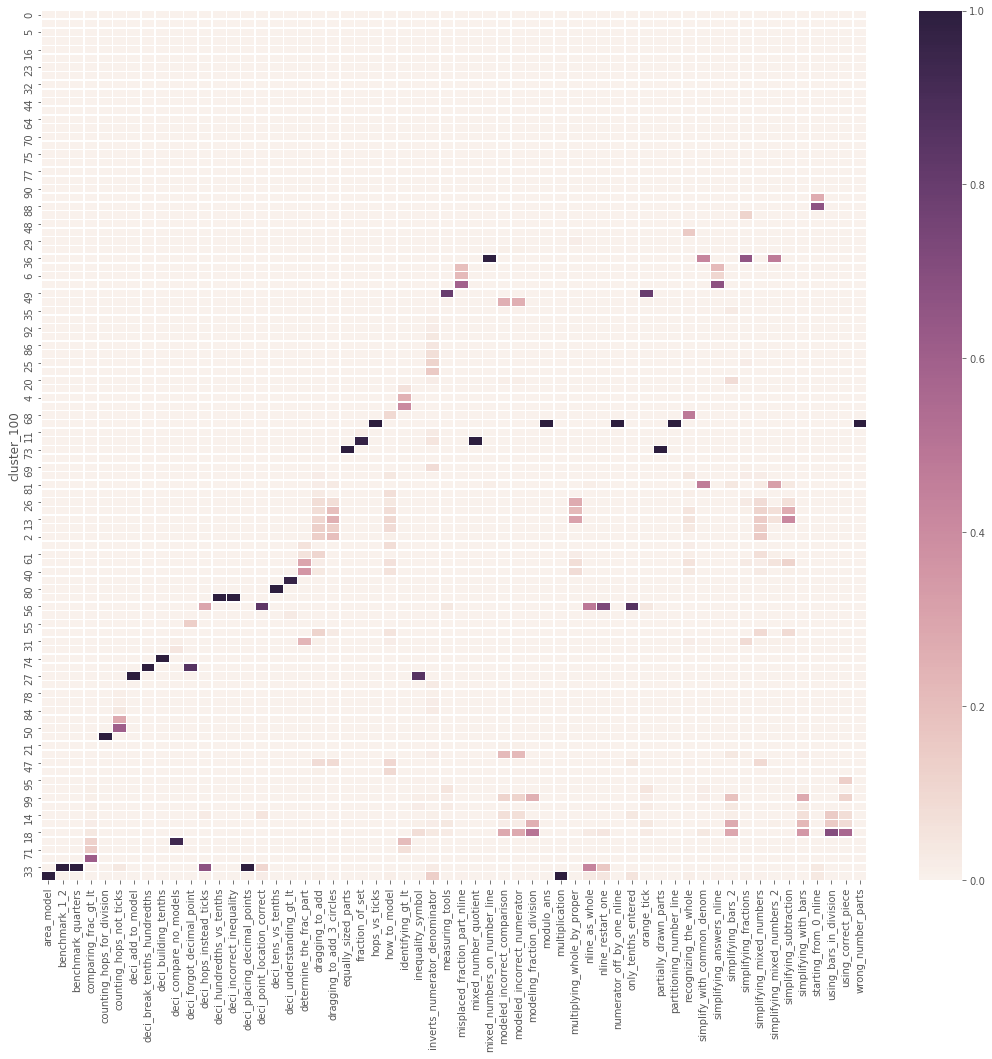

Extracting tf-idf features ...
done in 7.246s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=12, reassignment_ratio=0.01,
        tol=0.0, verbose=0)
done in 2.918s



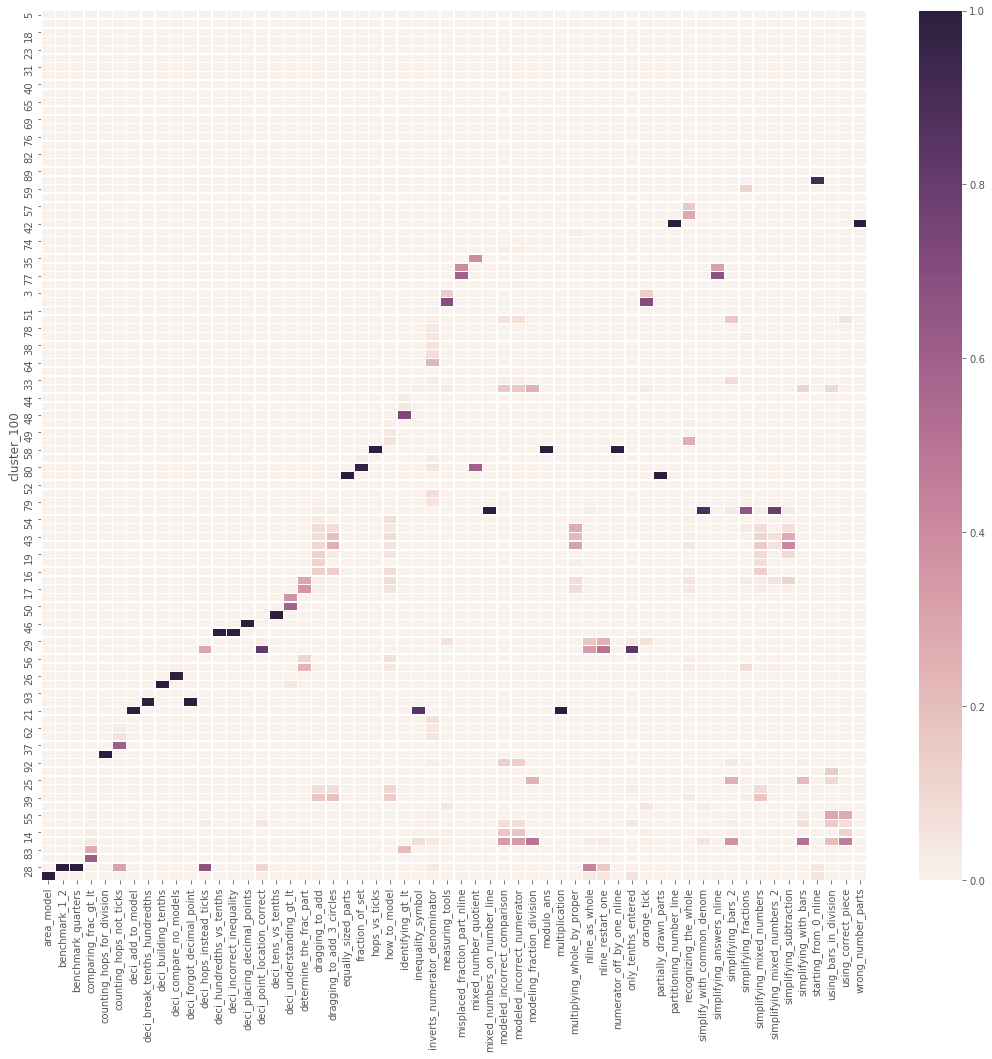

Extracting tf-idf features ...
done in 8.540s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=15, reassignment_ratio=0.01,
        tol=0.0, verbose=0)
done in 2.615s



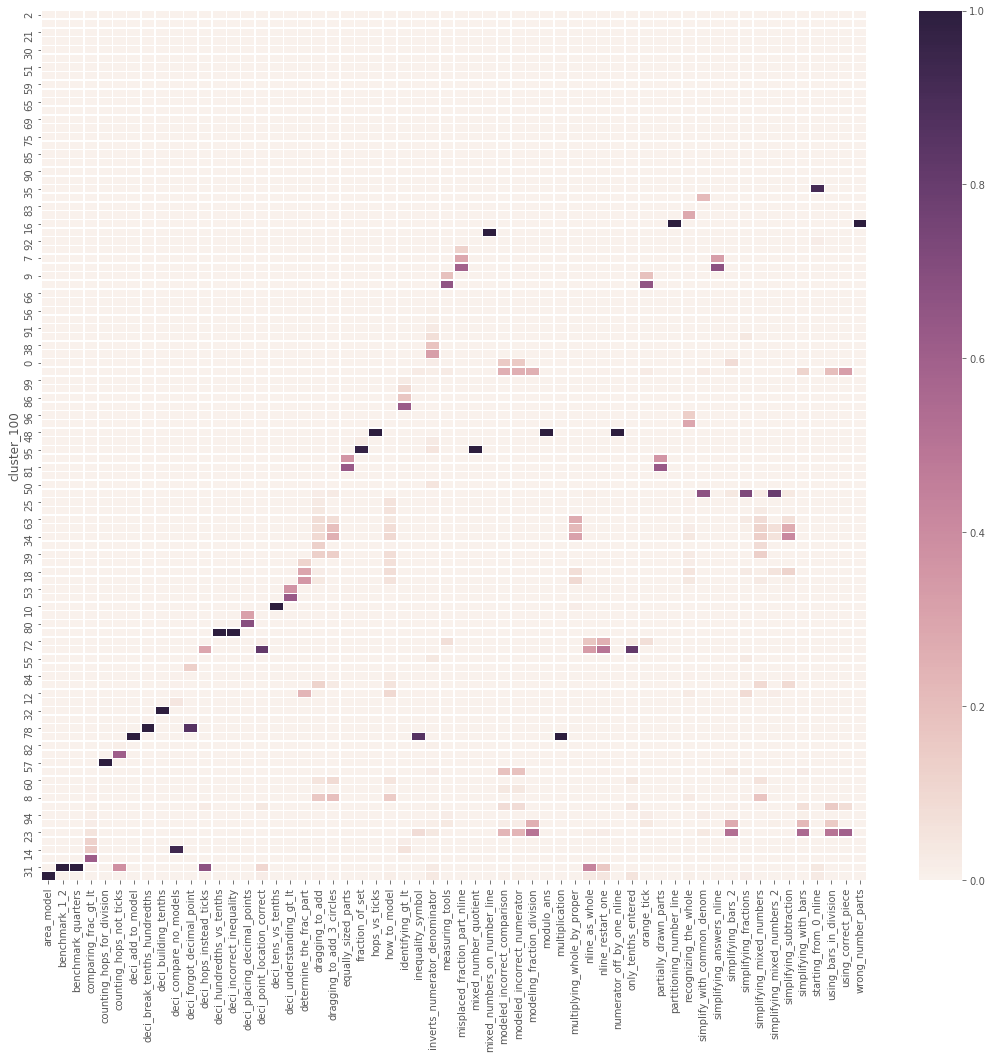

Extracting tf-idf features ...
done in 7.259s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=52, reassignment_ratio=0.01,
        tol=0.0, verbose=0)
done in 3.025s



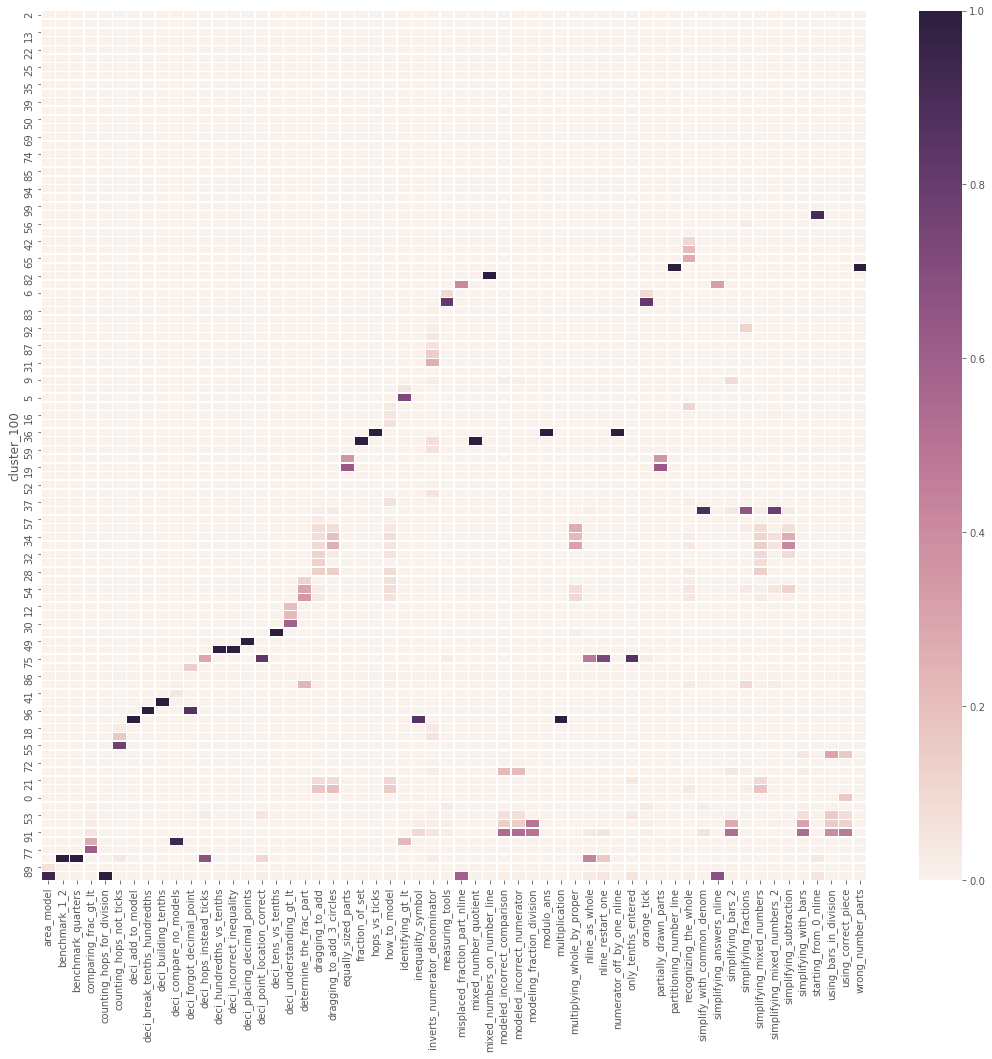

Extracting tf-idf features ...
done in 8.060s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=62, reassignment_ratio=0.01,
        tol=0.0, verbose=0)
done in 3.342s



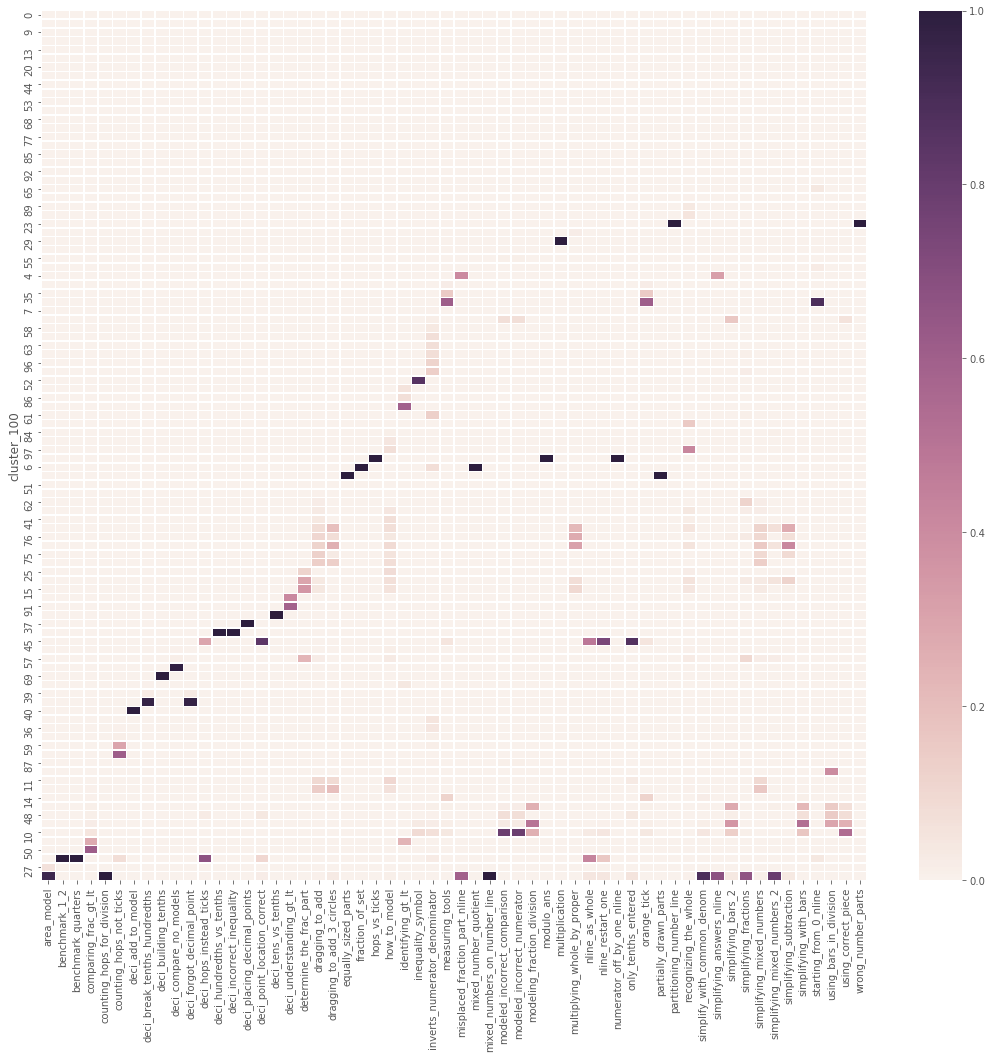

Extracting tf-idf features ...
done in 8.129s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=72, reassignment_ratio=0.01,
        tol=0.0, verbose=0)
done in 3.122s



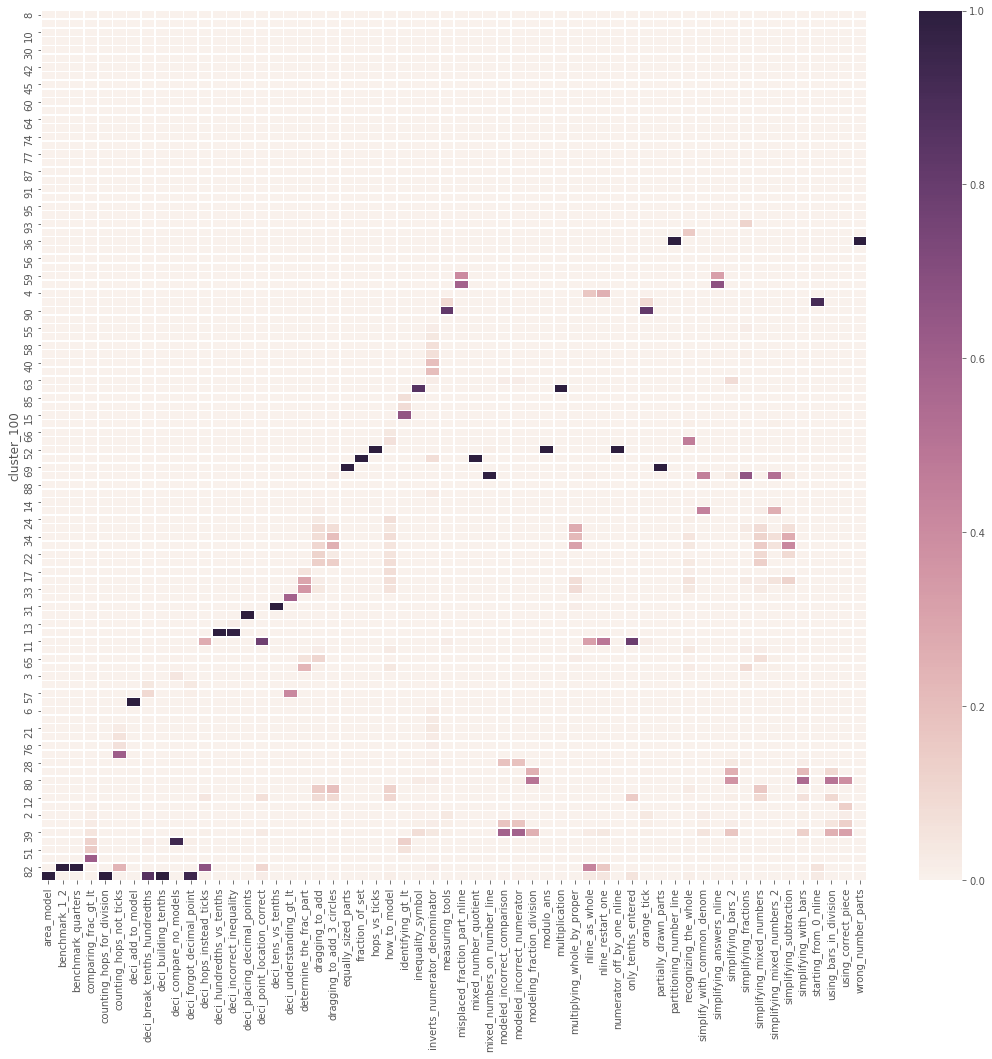

Extracting tf-idf features ...
done in 7.176s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=5, reassignment_ratio=0.01,
        tol=0.0, verbose=0)
done in 2.185s



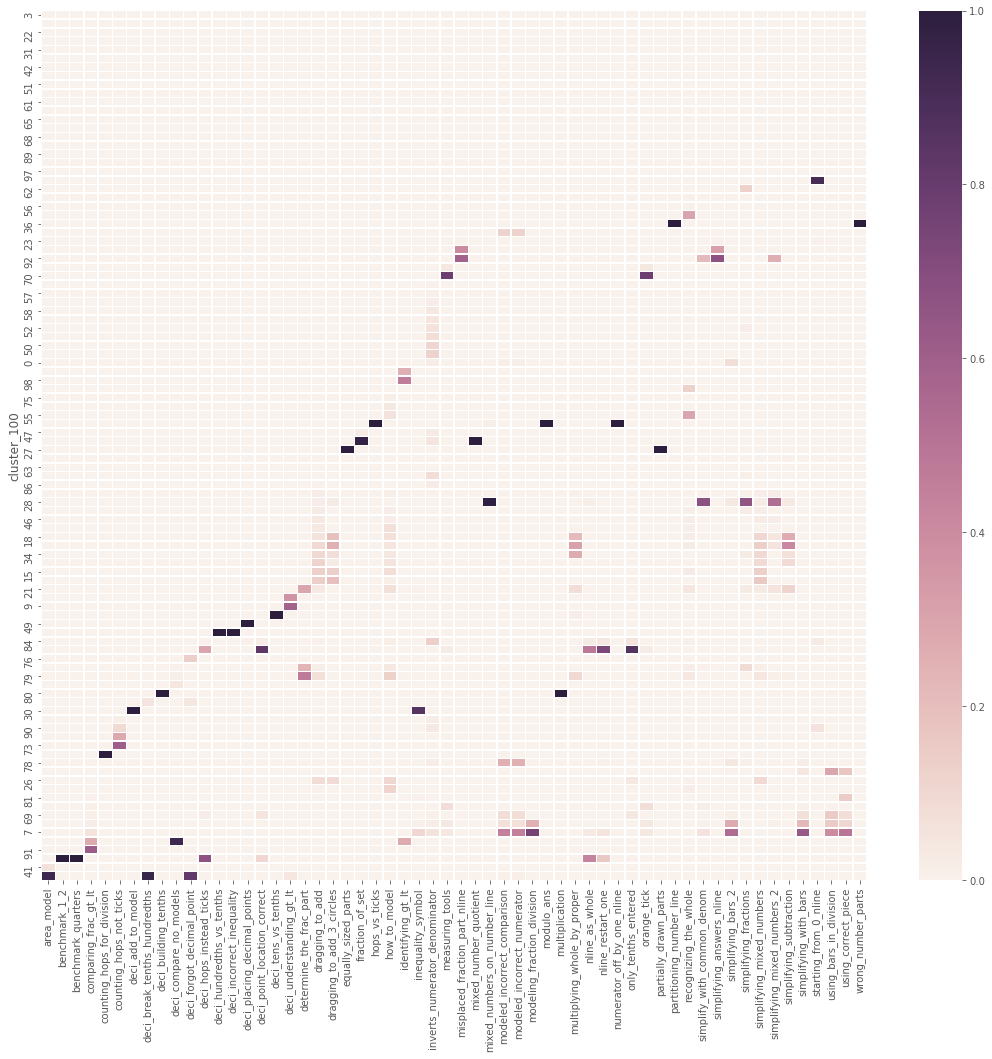

Extracting tf-idf features ...
done in 7.400s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=88, reassignment_ratio=0.01,
        tol=0.0, verbose=0)
done in 3.028s



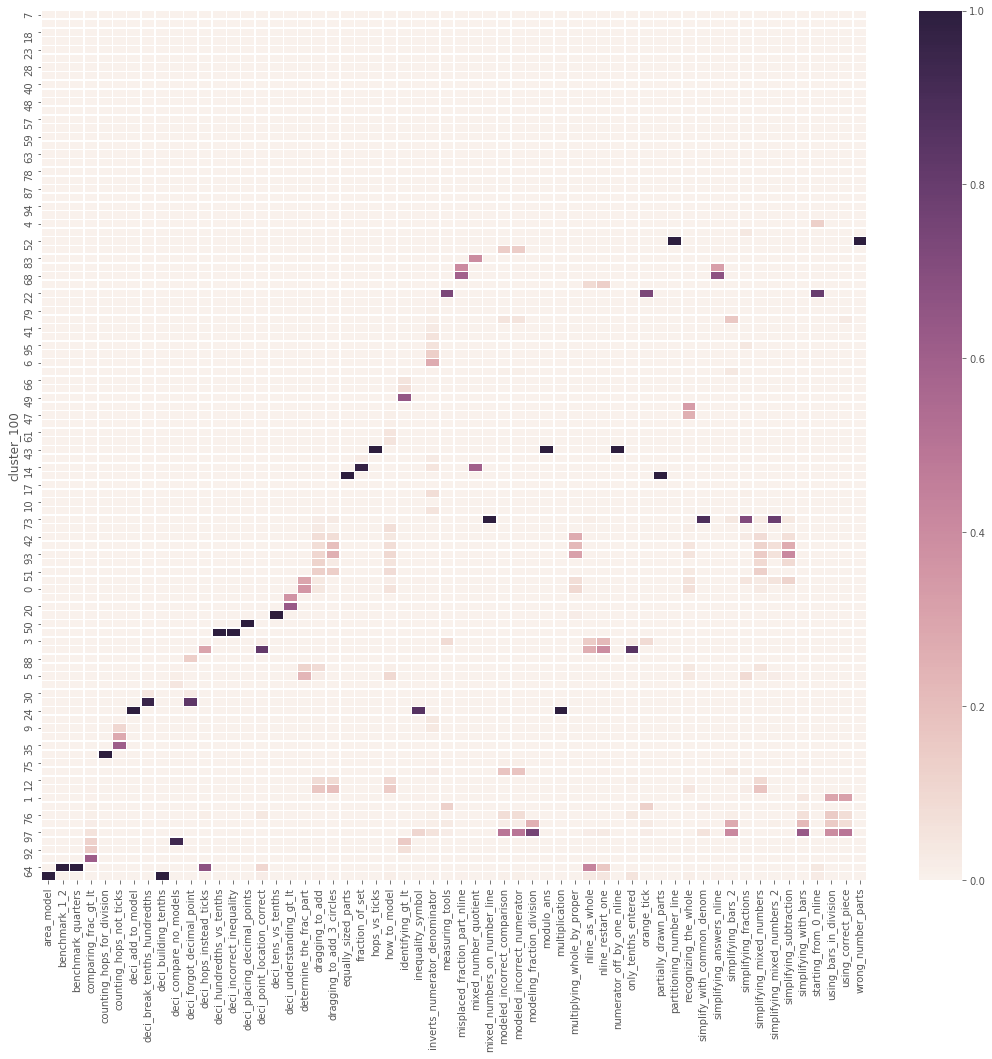

Extracting tf-idf features ...
done in 7.382s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=45, reassignment_ratio=0.01,
        tol=0.0, verbose=0)
done in 3.028s



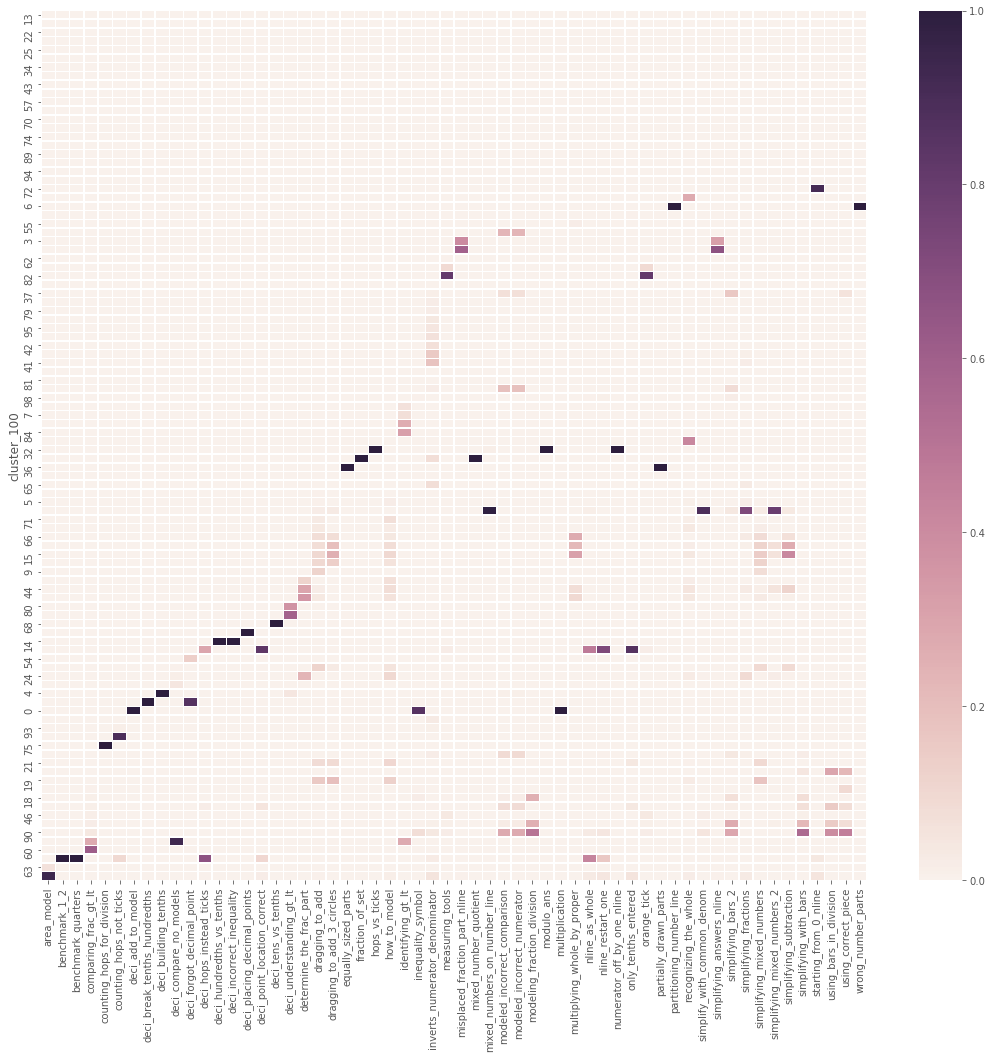

Extracting tf-idf features ...
done in 8.245s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=100,
        reassignment_ratio=0.01, tol=0.0, verbose=0)
done in 3.287s



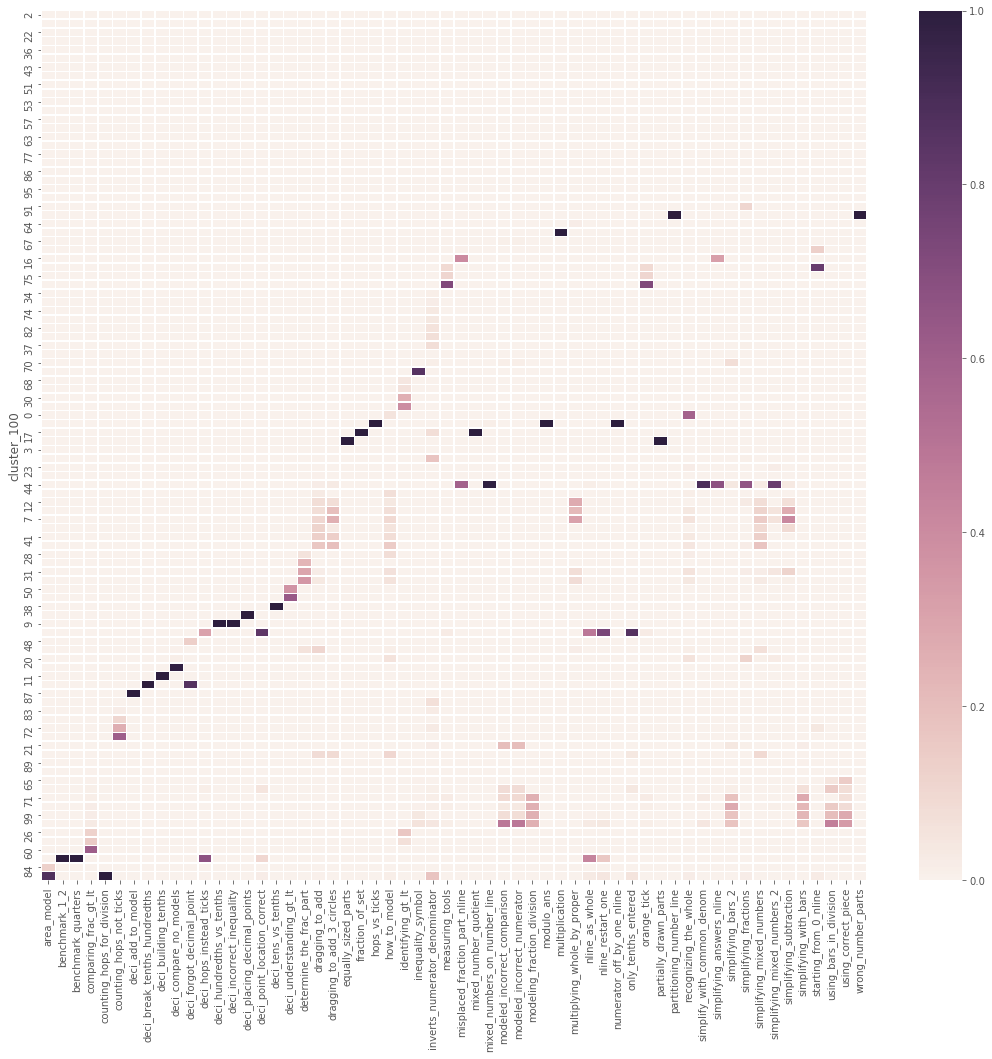

In [26]:
for state in random_states:
    km = make_cluster(data_samples,random_state=state)
    this_df = df3.copy()
    this_df = organize_clusters_and_traits(this_df, km)
    plot_trait_heat_map(this_df)
    